In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pylab as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor 
from sklearn.ensemble import VotingRegressor

from pandas_datareader import data
import math
import pandas_datareader as web
import datetime as dt
import urllib.request, json
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [52]:
# Loading the dataset
data_source = 'yahoo'
symbol='^NSEI'
def load_data(data_source,symbol):
    if data_source=='alphavantage':
        api_key="19UMWWWW21CB8VWU"
        url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(symbol,api_key)
        file_to_save='stock_market_data-%s.csv'%symbol

        if not os.path.exists(file_to_save):
            with urllib.request.urlopen(url_string) as url:
                data=json.loads(url.read().decode())
                data=data['Time Series (Daily)']
                ds=pd.dataframe(columns=['Date','Low','High','Close','Open'])
                for k,v in data.items():
                    date=dt.datetime.strptime(k,'%Y-%m-%d')
                    data_row=[date.date(),float(v['3. low']),float(v['2. high']),float(v['4. close']),float(v['1. open'])]
                    ds.loc[-1,:]=data_row
                    ds.index=ds.index+1
                print('Data saved to %s'%file_to_save)
                ds.to_csv(file_to_save)
        else:
            print('File already exists. Loading data from csv')
            ds=pd.read_csv(file_to_save)

    elif data_source=='kaggle':
        ds=pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
        print('Loaded data from kaggle repository')

    else:
        #ds = web.DataReader(symbol, data_source='yahoo', start='2007-01-01', end='2021-01-07')
        ds = web.get_data_yahoo('^NSEI','01/01/2010',interval='w')
    return ds

ds=load_data(data_source,symbol)
ds=ds.sort_values('Date')
ds.tail()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-31,14024.849609,13936.450195,13970.000000,13981.750000,452400.0,13981.750000
2021-01-04,14147.950195,13953.750000,14104.349609,14132.900391,495000.0,14132.900391
2021-01-05,14215.599609,14048.150391,14075.150391,14199.500000,492500.0,14199.500000
2021-01-06,14244.150391,14039.900391,14240.950195,14146.250000,632300.0,14146.250000
2021-01-07,14256.250000,14165.450195,14253.750000,14188.700195,0.0,14188.700195


In [3]:
print("\nSample Data")
print("===========\n")
print(ds.head())
print(ds.shape)


Sample Data

                   High          Low         Open        Close  Volume  \
Date                                                                     
2007-09-17  4549.049805  4482.850098  4518.450195  4494.649902     0.0   
2007-09-18  4551.799805  4481.549805  4494.100098  4546.200195     0.0   
2007-09-19  4739.000000  4550.250000  4550.250000  4732.350098     0.0   
2007-09-20  4760.850098  4721.149902  4734.850098  4747.549805     0.0   
2007-09-21  4855.700195  4733.700195  4752.950195  4837.549805     0.0   

              Adj Close  
Date                     
2007-09-17  4494.649902  
2007-09-18  4546.200195  
2007-09-19  4732.350098  
2007-09-20  4747.549805  
2007-09-21  4837.549805  
(3252, 6)


In [4]:
print("\n\nAttributes in Sample Data:")
print("==========================\n")

print(ds.columns)

print("\n\nNumber of Instances in Sample Data:")
print("========================================\n")
print(ds.iloc[: ,].count())



Attributes in Sample Data:

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')


Number of Instances in Sample Data:

High         3252
Low          3252
Open         3252
Close        3252
Volume       3252
Adj Close    3252
dtype: int64


In [5]:
# Dividing the dataset into input and otput

X = ds.drop("Close", axis = 1)
y = ds["Close"]

print(X.columns)

Index(['High', 'Low', 'Open', 'Volume', 'Adj Close'], dtype='object')


In [6]:
# Checking the datatypes of input and fetures

print(X.dtypes)
print(y.dtypes)

High         float64
Low          float64
Open         float64
Volume       float64
Adj Close    float64
dtype: object
float64


In [7]:
# Checking the correlation between various parameters

print(ds[["Open", "Close"]].corr(),"\n")
print(ds[["High", "Close"]].corr(),"\n")
print(ds[["Low", "Close"]].corr(),"\n")
print(ds[["Volume", "Close"]].corr())

           Open     Close
Open   1.000000  0.999527
Close  0.999527  1.000000 

           High     Close
High   1.000000  0.999777
Close  0.999777  1.000000 

            Low     Close
Low    1.000000  0.999747
Close  0.999747  1.000000 

          Volume     Close
Volume  1.000000  0.752674
Close   0.752674  1.000000


In [8]:
# Splitting of input and output data into Train and Test

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 0 , shuffle = False)

In [9]:
# Training our dataset using LinearRegression as model

model_LR = LinearRegression().fit(x_train, y_train)

print("\n\nScore on training data:")
print("========================================")
print("%.5f" %model_LR.score(x_train, y_train))

print("\n\nScore on testing data:")
print("========================================")
print("%.5f" %model_LR.score(x_test, y_test))

pickle.dump(model_LR, open ('D:\\Stock\\stockClosingPricePrediction-app-main\\models\\model_LR.pkl','wb'))




Score on training data:
1.00000


Score on testing data:
1.00000


In [10]:
y_pred_LR = model_LR.predict(x_test)
actual_data = np.array(y_test)

print("\n\nDifference between Actual value and Predicted value:")
print("========================================")

for i in range(len(y_pred_LR)):
    expl=((actual_data[i]-y_pred_LR[i])/actual_data[i])*100.0
    print('Actual Value {:,.2f}, Predicted value {:,.2f} (%{:,.2f})'.format(actual_data[i], y_pred_LR[i], expl))



Difference between Actual value and Predicted value:
Actual Value 7,899.15, Predicted value 7,899.15 (%0.00)
Actual Value 7,981.90, Predicted value 7,981.90 (%0.00)
Actual Value 7,977.10, Predicted value 7,977.10 (%0.00)
Actual Value 7,812.00, Predicted value 7,812.00 (%0.00)
Actual Value 7,845.95, Predicted value 7,845.95 (%0.00)
Actual Value 7,868.50, Predicted value 7,868.50 (%0.00)
Actual Value 7,795.70, Predicted value 7,795.70 (%0.00)
Actual Value 7,843.30, Predicted value 7,843.30 (%0.00)
Actual Value 7,948.90, Predicted value 7,948.90 (%0.00)
Actual Value 7,950.90, Predicted value 7,950.90 (%0.00)
Actual Value 8,119.30, Predicted value 8,119.30 (%0.00)
Actual Value 8,152.90, Predicted value 8,152.90 (%0.00)
Actual Value 8,177.40, Predicted value 8,177.40 (%0.00)
Actual Value 8,129.35, Predicted value 8,129.35 (%0.00)
Actual Value 8,189.70, Predicted value 8,189.70 (%0.00)
Actual Value 8,143.60, Predicted value 8,143.60 (%0.00)
Actual Value 8,131.70, Predicted value 8,131.70 (

In [11]:
print("\nEvaluation according to different parameters:")
print("========================================")

print("\nMean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_LR), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_LR), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_LR), 2)) 
print
("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_LR), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_LR), 2))


Evaluation according to different parameters:

Mean absolute error = 0.0
Mean squared error = 0.0
Median absolute error = 0.0
R2 score = 1.0


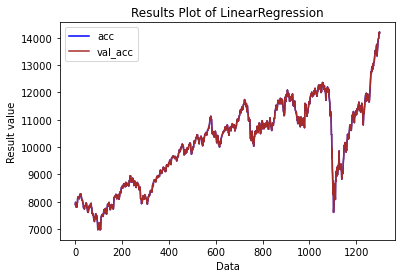

In [12]:
# Plotting the results

r = range(len(y_pred_LR))

plt.title("Results Plot of LinearRegression")
plt.plot(r, y_test, color='blue', label='acc')
plt.plot(r, y_pred_LR, color='brown', label='val_acc')
plt.xlabel("Data")
plt.ylabel("Result value")
plt.legend();

In [13]:
# Training our dataset using GradientBoostingRegressor as model

model_GBR = Pipeline([('scaler', StandardScaler()), ('model_GBR', GradientBoostingRegressor(random_state=0))])

model_GBR.fit(x_train, y_train)

print("\n\nScore on training data:")
print("========================================")
print("%.5f" %model_GBR.score(x_train, y_train))

print("\n\nScore on testing data:")
print("========================================")
print("%.5f" %model_GBR.score(x_test, y_test))

pickle.dump(model_GBR, open('D:\\Stock\\stockClosingPricePrediction-app-main\\models\\model_GBR.pkl', 'wb'))



Score on training data:
0.99995


Score on testing data:
-0.41802


In [14]:
y_pred_GBR = model_GBR.predict(x_test)
actual_data = np.array(y_test)

print("\n\nDifference between Actual value and Predicted value:")
print("========================================")

for i in range(len(y_pred_GBR)):
    expl=((actual_data[i]-y_pred_GBR[i])/actual_data[i])*100.0
    print('Actual Value ${:,.2f}, Predicted value ${:,.2f} (%{:,.2f})'.format(actual_data[i], y_pred_GBR[i], expl))



Difference between Actual value and Predicted value:
Actual Value $7,899.15, Predicted value $7,873.18 (%0.33)
Actual Value $7,981.90, Predicted value $7,990.03 (%-0.10)
Actual Value $7,977.10, Predicted value $7,974.10 (%0.04)
Actual Value $7,812.00, Predicted value $7,797.07 (%0.19)
Actual Value $7,845.95, Predicted value $7,835.46 (%0.13)
Actual Value $7,868.50, Predicted value $7,869.69 (%-0.02)
Actual Value $7,795.70, Predicted value $7,797.07 (%-0.02)
Actual Value $7,843.30, Predicted value $7,835.03 (%0.11)
Actual Value $7,948.90, Predicted value $7,942.81 (%0.08)
Actual Value $7,950.90, Predicted value $7,943.25 (%0.10)
Actual Value $8,119.30, Predicted value $8,135.31 (%-0.20)
Actual Value $8,152.90, Predicted value $8,135.31 (%0.22)
Actual Value $8,177.40, Predicted value $8,178.55 (%-0.01)
Actual Value $8,129.35, Predicted value $8,135.31 (%-0.07)
Actual Value $8,189.70, Predicted value $8,187.19 (%0.03)
Actual Value $8,143.60, Predicted value $8,137.91 (%0.07)
Actual Valu

In [15]:
print("\nEvaluation according to different parameters:")
print("========================================")

print("\nMean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_GBR), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_GBR), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_GBR), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_GBR), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_GBR), 2))


Evaluation according to different parameters:

Mean absolute error = 1355.13
Mean squared error = 3254521.56
Median absolute error = 1391.31
Explain variance score = 0.38
R2 score = -0.42


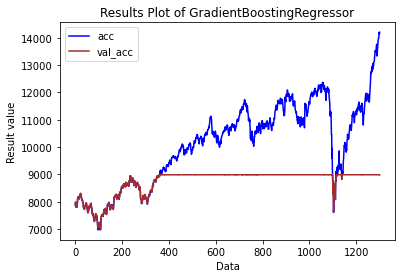

In [16]:
# Plotting the results

r = range(len(y_pred_GBR))

plt.title("Results Plot of GradientBoostingRegressor")
plt.plot(r, y_test, color='blue', label='acc')
plt.plot(r, y_pred_GBR, color='brown', label='val_acc')
plt.xlabel("Data")
plt.ylabel("Result value")
plt.legend()

In [17]:
# Training our dataset using RandomForestRegressor as model

model_RFR = Pipeline([('scaler', StandardScaler()), ('model_RFR', RandomForestRegressor(random_state=0))])
model_RFR.fit(x_train, y_train)

print("\n\nScore on training data:")
print("========================================")
print("%.5f" %model_RFR.score(x_train, y_train))

print("\n\nScore on testing data:")
print("========================================")
print("%.5f" %model_RFR.score(x_test, y_test))

pickle.dump(model_RFR, open('D:\\Stock\\stockClosingPricePrediction-app-main\\models\\model_RFR.pkl', 'wb'))



Score on training data:
1.00000


Score on testing data:
-0.43038


In [18]:
y_pred_RFR = model_RFR.predict(x_test)
actual_data = np.array(y_test)

print("\n\nDifference between Actual value and Predicted value:")
print("========================================")

for i in range(len(y_pred_RFR)):
    expl=((actual_data[i]-y_pred_RFR[i])/actual_data[i])*100.0
    print('Actual Value ${:,.2f}, Predicted value ${:,.2f} (%{:,.2f})'.format(actual_data[i], y_pred_RFR[i], expl))



Difference between Actual value and Predicted value:
Actual Value $7,899.15, Predicted value $7,896.67 (%0.03)
Actual Value $7,981.90, Predicted value $7,981.87 (%0.00)
Actual Value $7,977.10, Predicted value $7,974.10 (%0.04)
Actual Value $7,812.00, Predicted value $7,816.66 (%-0.06)
Actual Value $7,845.95, Predicted value $7,839.58 (%0.08)
Actual Value $7,868.50, Predicted value $7,869.38 (%-0.01)
Actual Value $7,795.70, Predicted value $7,795.74 (%-0.00)
Actual Value $7,843.30, Predicted value $7,835.82 (%0.10)
Actual Value $7,948.90, Predicted value $7,946.85 (%0.03)
Actual Value $7,950.90, Predicted value $7,952.08 (%-0.01)
Actual Value $8,119.30, Predicted value $8,113.49 (%0.07)
Actual Value $8,152.90, Predicted value $8,157.43 (%-0.06)
Actual Value $8,177.40, Predicted value $8,173.60 (%0.05)
Actual Value $8,129.35, Predicted value $8,129.09 (%0.00)
Actual Value $8,189.70, Predicted value $8,189.50 (%0.00)
Actual Value $8,143.60, Predicted value $8,146.70 (%-0.04)
Actual Valu

In [19]:
print("\nEvaluation according to different parameters:")
print("========================================")

print("\nMean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_RFR), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_RFR), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_RFR), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_RFR), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_RFR), 2))


Evaluation according to different parameters:

Mean absolute error = 1361.72
Mean squared error = 3282891.47
Median absolute error = 1400.9
Explain variance score = 0.37
R2 score = -0.43


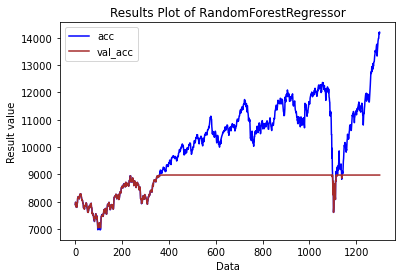

In [20]:
# Plotting the results

r = range(len(y_pred_RFR))

plt.title("Results Plot of RandomForestRegressor")
plt.plot(r, y_test, color='blue', label='acc')
plt.plot(r, y_pred_RFR, color='brown', label='val_acc')
plt.xlabel("Data")
plt.ylabel("Result value")
plt.legend()

In [21]:
# Training our dataset using SupportVectorRegressor as model

model_SVR = Pipeline([('scaler', StandardScaler()), ('model_SVR', SVR())])
model_SVR.fit(x_train, y_train)
# model_SVR = SVR().fit(x_train, y_train)

print("\n\nScore on training data:")
print("========================================")
print("%.5f" %model_SVR.score(x_train, y_train))

print("\n\nScore on testing data:")
print("========================================")
print("%.5f" %model_SVR.score(x_test, y_test))

pickle.dump(model_SVR, open('D:\\Stock\\stockClosingPricePrediction-app-main\\models\\model_SVR.pkl', 'wb'))




Score on training data:
0.29260


Score on testing data:
-8.32305


In [22]:
y_pred_SVR = model_SVR.predict(x_test)
actual_data = np.array(y_test)

print("\n\nDifference between Actual value and Predicted value:")
print("========================================")

for i in range(len(y_pred_SVR)):
    expl=((actual_data[i]-y_pred_SVR[i])/actual_data[i])*100.0
    print('Actual Value ${:,.2f}, Predicted value ${:,.2f} (%{:,.2f})'.format(actual_data[i], y_pred_SVR[i], expl))



Difference between Actual value and Predicted value:
Actual Value $7,899.15, Predicted value $6,027.92 (%23.69)
Actual Value $7,981.90, Predicted value $5,950.51 (%25.45)
Actual Value $7,977.10, Predicted value $6,019.10 (%24.55)
Actual Value $7,812.00, Predicted value $6,022.20 (%22.91)
Actual Value $7,845.95, Predicted value $6,032.04 (%23.12)
Actual Value $7,868.50, Predicted value $6,002.35 (%23.72)
Actual Value $7,795.70, Predicted value $6,029.37 (%22.66)
Actual Value $7,843.30, Predicted value $5,957.13 (%24.05)
Actual Value $7,948.90, Predicted value $5,991.35 (%24.63)
Actual Value $7,950.90, Predicted value $6,023.23 (%24.24)
Actual Value $8,119.30, Predicted value $6,007.13 (%26.01)
Actual Value $8,152.90, Predicted value $6,003.84 (%26.36)
Actual Value $8,177.40, Predicted value $5,993.45 (%26.71)
Actual Value $8,129.35, Predicted value $6,006.50 (%26.11)
Actual Value $8,189.70, Predicted value $5,987.00 (%26.90)
Actual Value $8,143.60, Predicted value $5,987.39 (%26.48)
A

In [23]:
print("\nEvaluation according to different parameters:")
print("========================================")

print("\nMean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_SVR), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_SVR), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_SVR), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_SVR), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_SVR), 2))


Evaluation according to different parameters:

Mean absolute error = 4328.26
Mean squared error = 21397492.32
Median absolute error = 4674.23
Explain variance score = -0.16
R2 score = -8.32


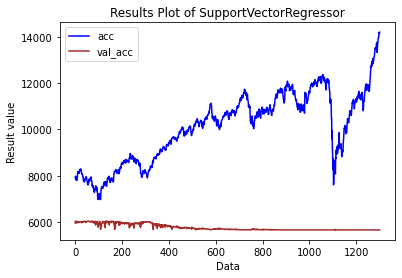

In [24]:
# Plotting the results

r = range(len(y_pred_SVR))

plt.title("Results Plot of SupportVectorRegressor")
plt.plot(r, y_test, color='blue', label='acc')
plt.plot(r, y_pred_SVR, color='brown', label='val_acc')
plt.xlabel("Data")
plt.ylabel("Result value")
plt.legend()

In [25]:
# Training our dataset using KernalRidgeRegressor as model

model_KRR = KernelRidge(alpha=1.0).fit(x_train, y_train)

print("\n\nScore on training data:")
print("========================================")
print("%.5f" %model_KRR.score(x_train, y_train))

print("\n\nScore on testing data:")
print("========================================")
print("%.5f" %model_KRR.score(x_test, y_test))

pickle.dump(model_KRR, open('D:\\Stock\\stockClosingPricePrediction-app-main\\models\\model_KRR.pkl', 'wb'))



Score on training data:
1.00000


Score on testing data:
1.00000


In [26]:
y_pred_KRR = model_KRR.predict(x_test)
actual_data = np.array(y_test)

print("\n\nDifference between Actual value and Predicted value:")
print("========================================")

for i in range(len(y_pred_KRR)):
    expl=((actual_data[i]-y_pred_KRR[i])/actual_data[i])*100.0
    print('Actual Value ${:,.2f}, Predicted value ${:,.2f} (%{:,.2f})'.format(actual_data[i], y_pred_KRR[i], expl))



Difference between Actual value and Predicted value:
Actual Value $7,899.15, Predicted value $7,899.15 (%0.00)
Actual Value $7,981.90, Predicted value $7,981.90 (%-0.00)
Actual Value $7,977.10, Predicted value $7,977.10 (%0.00)
Actual Value $7,812.00, Predicted value $7,812.00 (%-0.00)
Actual Value $7,845.95, Predicted value $7,845.95 (%0.00)
Actual Value $7,868.50, Predicted value $7,868.50 (%0.00)
Actual Value $7,795.70, Predicted value $7,795.70 (%-0.00)
Actual Value $7,843.30, Predicted value $7,843.30 (%-0.00)
Actual Value $7,948.90, Predicted value $7,948.90 (%0.00)
Actual Value $7,950.90, Predicted value $7,950.90 (%-0.00)
Actual Value $8,119.30, Predicted value $8,119.30 (%0.00)
Actual Value $8,152.90, Predicted value $8,152.90 (%0.00)
Actual Value $8,177.40, Predicted value $8,177.40 (%0.00)
Actual Value $8,129.35, Predicted value $8,129.35 (%0.00)
Actual Value $8,189.70, Predicted value $8,189.70 (%0.00)
Actual Value $8,143.60, Predicted value $8,143.60 (%-0.00)
Actual Valu

In [27]:
print("\nEvaluation according to different parameters:")
print("========================================")

print("\nMean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_KRR), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_KRR), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_KRR), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_KRR), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_KRR), 2))


Evaluation according to different parameters:

Mean absolute error = 0.0
Mean squared error = 0.0
Median absolute error = 0.0
Explain variance score = 1.0
R2 score = 1.0


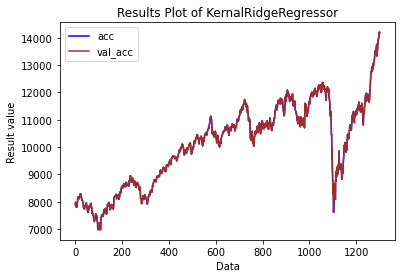

In [28]:
# Plotting the results

r = range(len(y_pred_KRR))

plt.title("Results Plot of KernalRidgeRegressor")
plt.plot(r, y_test, color='blue', label='acc')
plt.plot(r, y_pred_KRR, color='brown', label='val_acc')
plt.xlabel("Data")
plt.ylabel("Result value")
plt.legend()

In [29]:
# Training our dataset using BayesianRidgeRegressor as model

model_BRR = BayesianRidge().fit(x_train, y_train)

print("\n\nScore on training data:")
print("========================================")
print("%.5f" %model_BRR.score(x_train, y_train))

print("\n\nScore on testing data:")
print("========================================")
print("%.5f" %model_BRR.score(x_test, y_test))

pickle.dump(model_BRR, open('D:\\Stock\\stockClosingPricePrediction-app-main\\models\\model_BRR.pkl', 'wb'))




Score on training data:
1.00000


Score on testing data:
1.00000


In [30]:
y_pred_BRR = model_BRR.predict(x_test)
actual_data = np.array(y_test)

print("\n\nDifference between Actual value and Predicted value:")
print("========================================")

for i in range(len(y_pred_BRR)):
    expl=((actual_data[i]-y_pred_BRR[i])/actual_data[i])*100.0
    print('Actual Value ${:,.2f}, Predicted value ${:,.2f} (%{:,.2f})'.format(actual_data[i], y_pred_BRR[i], expl))



Difference between Actual value and Predicted value:
Actual Value $7,899.15, Predicted value $7,899.15 (%0.00)
Actual Value $7,981.90, Predicted value $7,981.90 (%0.00)
Actual Value $7,977.10, Predicted value $7,977.10 (%0.00)
Actual Value $7,812.00, Predicted value $7,812.00 (%-0.00)
Actual Value $7,845.95, Predicted value $7,845.95 (%0.00)
Actual Value $7,868.50, Predicted value $7,868.50 (%0.00)
Actual Value $7,795.70, Predicted value $7,795.70 (%0.00)
Actual Value $7,843.30, Predicted value $7,843.30 (%0.00)
Actual Value $7,948.90, Predicted value $7,948.90 (%-0.00)
Actual Value $7,950.90, Predicted value $7,950.90 (%0.00)
Actual Value $8,119.30, Predicted value $8,119.30 (%0.00)
Actual Value $8,152.90, Predicted value $8,152.90 (%-0.00)
Actual Value $8,177.40, Predicted value $8,177.40 (%0.00)
Actual Value $8,129.35, Predicted value $8,129.35 (%0.00)
Actual Value $8,189.70, Predicted value $8,189.70 (%0.00)
Actual Value $8,143.60, Predicted value $8,143.60 (%0.00)
Actual Value $

In [31]:
y_pred_BRR

array([ 7899.14990234,  7981.89990234,  7977.10009766, ...,
       14199.5       , 14146.25      , 14193.        ])

In [32]:
print("\nEvaluation according to different parameters:")
print("========================================")

print("\nMean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_BRR), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_BRR), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_BRR), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_BRR), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_BRR), 2))


Evaluation according to different parameters:

Mean absolute error = 0.0
Mean squared error = 0.0
Median absolute error = 0.0
Explain variance score = 1.0
R2 score = 1.0


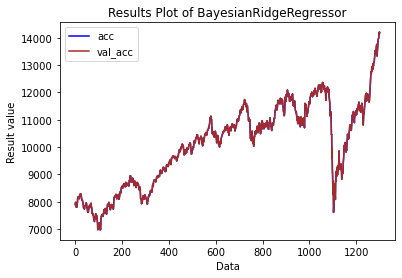

In [33]:
# Plotting the results

r = range(len(y_pred_KRR))

plt.title("Results Plot of BayesianRidgeRegressor")
plt.plot(r, y_test, color='blue', label='acc')
plt.plot(r, y_pred_BRR, color='brown', label='val_acc')
plt.xlabel("Data")
plt.ylabel("Result value")
plt.legend();

In [34]:
# Training our dataset using LassoRegressor as model

model_LSS = Lasso(alpha = 1).fit(x_train, y_train)

print("\n\nScore on training data:")
print("========================================")
print("%.5f" %model_LSS.score(x_train, y_train))

print("\n\nScore on testing data:")
print("========================================")
print("%.5f" %model_LSS.score(x_test, y_test))

pickle.dump(model_LSS, open('D:\\Stock\\stockClosingPricePrediction-app-main\\models\\model_LSS.pkl', 'wb'))



Score on training data:
0.99988


Score on testing data:
0.99988


In [35]:
y_pred_LSS = model_LSS.predict(x_test)
actual_data = np.array(y_test)

print("\n\nDifference between Actual value and Predicted value:")
print("========================================")

for i in range(len(y_pred_LSS)):
    expl=((actual_data[i]-y_pred_LSS[i])/actual_data[i])*100.0
    print('Actual Value ${:,.2f}, Predicted value ${:,.2f} (%{:,.2f})'.format(actual_data[i], y_pred_LSS[i], expl))



Difference between Actual value and Predicted value:
Actual Value $7,899.15, Predicted value $7,890.63 (%0.11)
Actual Value $7,981.90, Predicted value $8,007.26 (%-0.32)
Actual Value $7,977.10, Predicted value $7,975.88 (%0.02)
Actual Value $7,812.00, Predicted value $7,837.24 (%-0.32)
Actual Value $7,845.95, Predicted value $7,853.16 (%-0.09)
Actual Value $7,868.50, Predicted value $7,864.57 (%0.05)
Actual Value $7,795.70, Predicted value $7,805.40 (%-0.12)
Actual Value $7,843.30, Predicted value $7,865.52 (%-0.28)
Actual Value $7,948.90, Predicted value $7,932.12 (%0.21)
Actual Value $7,950.90, Predicted value $7,954.27 (%-0.04)
Actual Value $8,119.30, Predicted value $8,117.91 (%0.02)
Actual Value $8,152.90, Predicted value $8,135.39 (%0.21)
Actual Value $8,177.40, Predicted value $8,173.39 (%0.05)
Actual Value $8,129.35, Predicted value $8,128.62 (%0.01)
Actual Value $8,189.70, Predicted value $8,190.23 (%-0.01)
Actual Value $8,143.60, Predicted value $8,154.91 (%-0.14)
Actual Va

In [36]:
print("\nEvaluation according to different parameters:")
print("========================================")

print("\nMean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_LSS), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_LSS), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_LSS), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_LSS), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_LSS), 2))


Evaluation according to different parameters:

Mean absolute error = 10.83
Mean squared error = 268.17
Median absolute error = 7.51
Explain variance score = 1.0
R2 score = 1.0


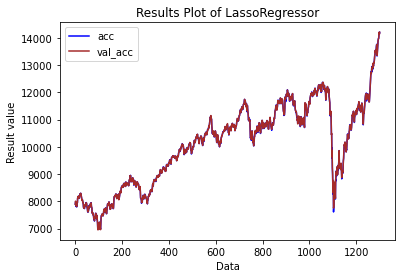

In [37]:
# Plotting the results

r = range(len(y_pred_LSS))

plt.title("Results Plot of LassoRegressor")
plt.plot(r, y_test, color='blue', label='acc')
plt.plot(r, y_pred_LSS, color='brown', label='val_acc')
plt.xlabel("Data")
plt.ylabel("Result value")
plt.legend()

In [38]:
# Training our dataset using DecisionTreeRegressor as model

model_DTR = DecisionTreeRegressor(random_state = 10).fit(x_train, y_train)

print("\n\nScore on training data:")
print("========================================")
print("%.5f" %model_DTR.score(x_train, y_train))

print("\n\nScore on testing data:")
print("========================================")
print("%.5f" %model_DTR.score(x_test, y_test))

pickle.dump(model_DTR, open('D:\\Stock\\stockClosingPricePrediction-app-main\\models\\model_DTR.pkl', 'wb'))




Score on training data:
1.00000


Score on testing data:
-0.44861


In [39]:
y_pred_DTR = model_DTR.predict(x_test)
actual_data = np.array(y_test)

print("\n\nDifference between Actual value and Predicted value:")
print("========================================")

for i in range(len(y_pred_DTR)):
    expl=((actual_data[i]-y_pred_DTR[i])/actual_data[i])*100.0
    print('Actual Value ${:,.2f}, Predicted value ${:,.2f} (%{:,.2f})'.format(actual_data[i], y_pred_DTR[i], expl))



Difference between Actual value and Predicted value:
Actual Value $7,899.15, Predicted value $7,891.10 (%0.10)
Actual Value $7,981.90, Predicted value $7,995.90 (%-0.18)
Actual Value $7,977.10, Predicted value $7,975.50 (%0.02)
Actual Value $7,812.00, Predicted value $7,818.60 (%-0.08)
Actual Value $7,845.95, Predicted value $7,829.10 (%0.21)
Actual Value $7,868.50, Predicted value $7,872.25 (%-0.05)
Actual Value $7,795.70, Predicted value $7,791.70 (%0.05)
Actual Value $7,843.30, Predicted value $7,829.10 (%0.18)
Actual Value $7,948.90, Predicted value $7,948.95 (%-0.00)
Actual Value $7,950.90, Predicted value $7,945.55 (%0.07)
Actual Value $8,119.30, Predicted value $8,124.45 (%-0.06)
Actual Value $8,152.90, Predicted value $8,159.30 (%-0.08)
Actual Value $8,177.40, Predicted value $8,174.60 (%0.03)
Actual Value $8,129.35, Predicted value $8,130.65 (%-0.02)
Actual Value $8,189.70, Predicted value $8,200.70 (%-0.13)
Actual Value $8,143.60, Predicted value $8,135.10 (%0.10)
Actual Va

In [40]:
print("\nEvaluation according to different parameters:")
print("========================================")

print("\nMean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_DTR), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_DTR), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_DTR), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_DTR), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_DTR), 2))


Evaluation according to different parameters:

Mean absolute error = 1370.35
Mean squared error = 3324729.38
Median absolute error = 1393.45
Explain variance score = 0.37
R2 score = -0.45


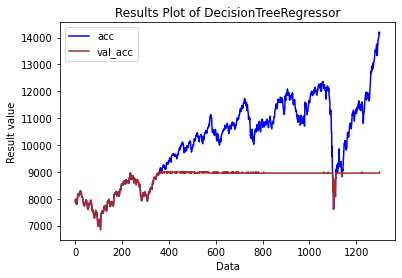

In [41]:
# Plotting the results

r = range(len(y_pred_DTR))

plt.title("Results Plot of DecisionTreeRegressor")
plt.plot(r, y_test, color='blue', label='acc')
plt.plot(r, y_pred_DTR, color='brown', label='val_acc')
plt.xlabel("Data")
plt.ylabel("Result value")
plt.legend()

In [42]:
# Training our dataset using MultiLayeredPerceptronRegressor as model

model_MLP = MLPRegressor(random_state=0, max_iter=100).fit(x_train, y_train)

print("\n\nScore on training data:")
print("========================================")
print("%.5f" %model_MLP.score(x_train, y_train))

print("\n\nScore on testing data:")
print("========================================")
print("%.5f" %model_MLP.score(x_test, y_test))

pickle.dump(model_MLP, open('D:\\Stock\\stockClosingPricePrediction-app-main\\models\\model_MLP.pkl', 'wb'))



Score on training data:
0.99940


Score on testing data:
0.97552


In [43]:
y_pred_MLP = model_MLP.predict(x_test)
actual_data = np.array(y_test)

print("\n\nDifference between Actual value and Predicted value:")
print("========================================")

for i in range(len(y_pred_MLP)):
    expl=((actual_data[i]-y_pred_MLP[i])/actual_data[i])*100.0
    print('Actual Value ${:,.2f}, Predicted value ${:,.2f} (%{:,.2f})'.format(actual_data[i], y_pred_MLP[i], expl))



Difference between Actual value and Predicted value:
Actual Value $7,899.15, Predicted value $7,889.84 (%0.12)
Actual Value $7,981.90, Predicted value $7,979.85 (%0.03)
Actual Value $7,977.10, Predicted value $7,953.33 (%0.30)
Actual Value $7,812.00, Predicted value $7,908.98 (%-1.24)
Actual Value $7,845.95, Predicted value $7,816.74 (%0.37)
Actual Value $7,868.50, Predicted value $7,854.07 (%0.18)
Actual Value $7,795.70, Predicted value $7,836.77 (%-0.53)
Actual Value $7,843.30, Predicted value $7,818.59 (%0.32)
Actual Value $7,948.90, Predicted value $7,931.72 (%0.22)
Actual Value $7,950.90, Predicted value $7,965.35 (%-0.18)
Actual Value $8,119.30, Predicted value $8,079.50 (%0.49)
Actual Value $8,152.90, Predicted value $8,156.34 (%-0.04)
Actual Value $8,177.40, Predicted value $8,158.82 (%0.23)
Actual Value $8,129.35, Predicted value $8,152.96 (%-0.29)
Actual Value $8,189.70, Predicted value $8,186.43 (%0.04)
Actual Value $8,143.60, Predicted value $8,179.39 (%-0.44)
Actual Valu

In [44]:
print("\nEvaluation according to different parameters:")
print("========================================")

print("\nMean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_MLP), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_MLP), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_MLP), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_MLP), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_MLP), 2))


Evaluation according to different parameters:

Mean absolute error = 61.61
Mean squared error = 56180.24
Median absolute error = 20.46
Explain variance score = 0.98
R2 score = 0.98


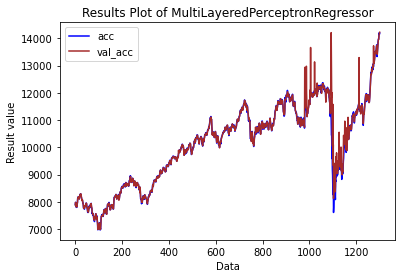

In [45]:
# Plotting the results

r = range(len(y_pred_DTR))

plt.title("Results Plot of MultiLayeredPerceptronRegressor")
plt.plot(r, y_test, color='blue', label='acc')
plt.plot(r, y_pred_MLP, color='brown', label='val_acc')
plt.xlabel("Data")
plt.ylabel("Result value")
plt.legend()

In [46]:
# Training our dataset using VotingRegressor as model

model_VR = VotingRegressor(estimators=[('ml', model_LR), ('msv', model_SVR)])
model_VR.fit(x_train, y_train)

print("\n\nScore on training data:")
print("========================================")
print("%.5f" %model_VR.score(x_train, y_train))

print("\n\nScore on testing data:")
print("========================================")
print("%.5f" %model_VR.score(x_test, y_test))

pickle.dump(model_VR, open('D:\\Stock\\stockClosingPricePrediction-app-main\\models\\model_VR.pkl', 'wb'))



Score on training data:
0.82315


Score on testing data:
-1.33076


In [47]:
y_pred_VR = model_MLP.predict(x_test)
actual_data = np.array(y_test)

print("\n\nDifference between Actual value and Predicted value:")
print("========================================")

for i in range(len(y_pred_VR)):
    expl=((actual_data[i]-y_pred_VR[i])/actual_data[i])*100.0
    print('Actual Value ${:,.2f}, Predicted value ${:,.2f} (%{:,.2f})'.format(actual_data[i], y_pred_VR[i], expl))



Difference between Actual value and Predicted value:
Actual Value $7,899.15, Predicted value $7,889.84 (%0.12)
Actual Value $7,981.90, Predicted value $7,979.85 (%0.03)
Actual Value $7,977.10, Predicted value $7,953.33 (%0.30)
Actual Value $7,812.00, Predicted value $7,908.98 (%-1.24)
Actual Value $7,845.95, Predicted value $7,816.74 (%0.37)
Actual Value $7,868.50, Predicted value $7,854.07 (%0.18)
Actual Value $7,795.70, Predicted value $7,836.77 (%-0.53)
Actual Value $7,843.30, Predicted value $7,818.59 (%0.32)
Actual Value $7,948.90, Predicted value $7,931.72 (%0.22)
Actual Value $7,950.90, Predicted value $7,965.35 (%-0.18)
Actual Value $8,119.30, Predicted value $8,079.50 (%0.49)
Actual Value $8,152.90, Predicted value $8,156.34 (%-0.04)
Actual Value $8,177.40, Predicted value $8,158.82 (%0.23)
Actual Value $8,129.35, Predicted value $8,152.96 (%-0.29)
Actual Value $8,189.70, Predicted value $8,186.43 (%0.04)
Actual Value $8,143.60, Predicted value $8,179.39 (%-0.44)
Actual Valu

In [48]:
print("\nEvaluation according to different parameters:")
print("========================================")

print("\nMean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_VR), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_VR), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_VR), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_VR), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_VR), 2))


Evaluation according to different parameters:

Mean absolute error = 61.61
Mean squared error = 56180.24
Median absolute error = 20.46
Explain variance score = 0.98
R2 score = 0.98


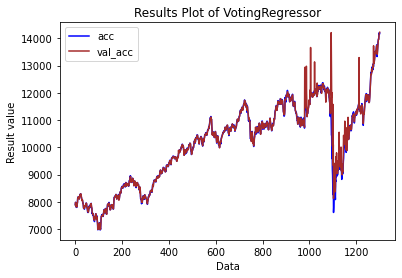

In [49]:
# Plotting the results

r = range(len(y_pred_DTR))

plt.title("Results Plot of VotingRegressor")
plt.plot(r, y_test, color='blue', label='acc')
plt.plot(r, y_pred_VR, color='brown', label='val_acc')
plt.xlabel("Data")
plt.ylabel("Result value")
plt.legend()